# Parameterisation for submesoscale vertical buoyancy flux : APE

__author__ : Aurélie Albert & Julien Le Sommer (MEOM, IGE)

__contributing author__ : Adekunle Ajayi (MEOM, IGE)

__context__ : 22-GLO-HR project : Lot 1 - Ocean Modelling

__date__ : 7 March 2018, revised in May, 23 2018

__purpose__ : Metric for the conversion rate of available potential energy to eddy kinetic energy in NATL60-CJM165 simulation

__detailed description__ : 
Fox-Kemper et al., 2008 proposed that the total conversion rate of the available potential energy follows the evolution of large scale available potential energy (APE) which can be estimated as :

$$\mathcal APE = \langle w^{'}b^{'} \rangle_{xyz} \propto (\langle h \rangle_{xy}) ^{2} \cdot \langle \nabla_{h} \bar{b} \rangle_{xyz}$$


In the equation above, h, <>xy, <>xyz represents the mixed layer depth, horizontal averaging over region, and volume averaging over region respectively. Overbar signify large scale flow quantity.

__practical steps__ :

  * Input data are NATL60-CJM165 daily outputs of temperature and salinity for one whole year (October 2012 to September 2013)
  * step 1. : The daily mixed layer depth is computed from 3D T and S fields with cdfmxl cdftool : https://github.com/meom-group/CDFTOOLS : the computation is done on occigen servers
  * step 2. : Surface buoyancy is computed from T and S fields with cdfbuoy cdftool.
  * step 3. : Buoyancy is spatially filtered to remove the fine scales with the Lanczos2DHighPassFilter.py script written in the framework of the Vorticity Variance metric (see https://gitlab.com/meom-group-private/cmems-22-glo-hr-codes/tree/master/Task1-fine-scale-metrics/Vorticity-variance) : the computation is done on occigen servers
  * step 4. : The horizontal gradient of large scale buoyancy is computed with cdfhgrad cdftool : the computation is done on occigen servers   
  * step 5. : 10°x10° boxes already defined in the framework of the Kinetic energy wavenumber spectra are implemented (see https://gitlab.com/meom-group-private/cmems-22-glo-hr-codes/blob/master/Task1-fine-scale-metrics/Wavenumber-spectrum/cmems-glo-hr_demo-fine-scale-metrics_02_kinetic-energy-wavenumber-spectra.ipynb)
  * step 6. : The product of the squared average mixed layer depth and average large scale horizontal gradient of buoyancy is computed for each box and daily outputs
  * step 7. : Plots of the yearly time series are produced for each box
  
__external libraries needed to run this script__ : 

 * Definition of 10°x10° for NATL60 grid :natl60_10_by_10_boxes.py
 * Tools for plot in boxes : plot_box
 
__licence__ : This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

## 0. Importing external modules

In [1]:
## magics

%load_ext version_information 
%version_information numpy,xarray,netCDF4, matplotlib


Software versions
Python 2.7.11 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.5
numpy 1.11.2
xarray 0.9.1
netCDF4 1.2.4
matplotlib 2.0.2
Wed May 23 16:15:29 2018 CEST

In [2]:
## path for modules

import sys
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy.ma as ma

sys.path.insert(0,'/home/albert/lib/python/AJ-spectre/')
from natl60_10_by_10_boxes import boxes
import plot_box as pb

%matplotlib inline
%autosave 60

Autosaving every 60 seconds


## 1. Loading daily outputs of mixed layer depth and large scale horizontal gradient of buoyancy

In [3]:
database = '/media/extra/DATA/NATL60/NATL60-CJM165-S/'
mldfiles = sorted(glob.glob(database + 'MXL/NATL60-CJM165_y2*_somxl010.nc'))
gradbfiles = sorted(glob.glob(database + 'hgrad-large-scale/NATL60-CJM165_y2*_hgradb_large_scale.nc'))


In [4]:
time_counter=xr.open_mfdataset(mldfiles)['time_counter']

## 2. Defining the computation in boxes

In [5]:
def get_values_in_box(box,data):
    jmin,jmax = box.jmin,box.jmax
    imin,imax = box.imin,box.imax
    values = data[jmin:jmax+1,imin:imax+1]
    return values


In [6]:
def Estimate_wb(box,mld,gradb):
    mld_box = get_values_in_box(box,mld)
    gradb_box = get_values_in_box(box,gradb)    
    # - compute average
    avg_mld_box = mld_box.mean()
    avg_gradb_box = gradb_box.mean()
    # - compute w'b'
    wb_box = (avg_mld_box**2)*avg_gradb_box
    return wb_box

In [7]:
def get_wb_in_boxes(mldfiles,gradbfiles):
    global boxes
    _Ann_wb_arr = []
    for i in range(len(gradbfiles)): 
        if i%30 == 0: print mldfiles[i]
        mld = xr.open_dataset(mldfiles[i])['somxl010']
        gradb = xr.open_dataset(gradbfiles[i])['vohgradb']
        mld = mld.squeeze() ; gradb = gradb.squeeze();
        _wb_arr = []
        for box in boxes:
            wb = Estimate_wb(box,mld,gradb)
            _wb_arr.append(wb)
        wb_arr = np.array(_wb_arr)
        _Ann_wb_arr.append(wb_arr)
    Ann_wb_arr = np.array(_Ann_wb_arr)
    return Ann_wb_arr

## 3. Loop on the boxes and the input files

In [9]:
wb_boxes_yr = get_wb_in_boxes(mldfiles,gradbfiles)

/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2012m10d01.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2012m10d31.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2012m11d30.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2012m12d30.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m01d29.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m02d28.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d30.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m04d29.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m05d29.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m06d28.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m07d28.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJ

## 4. Time series plots in boxes

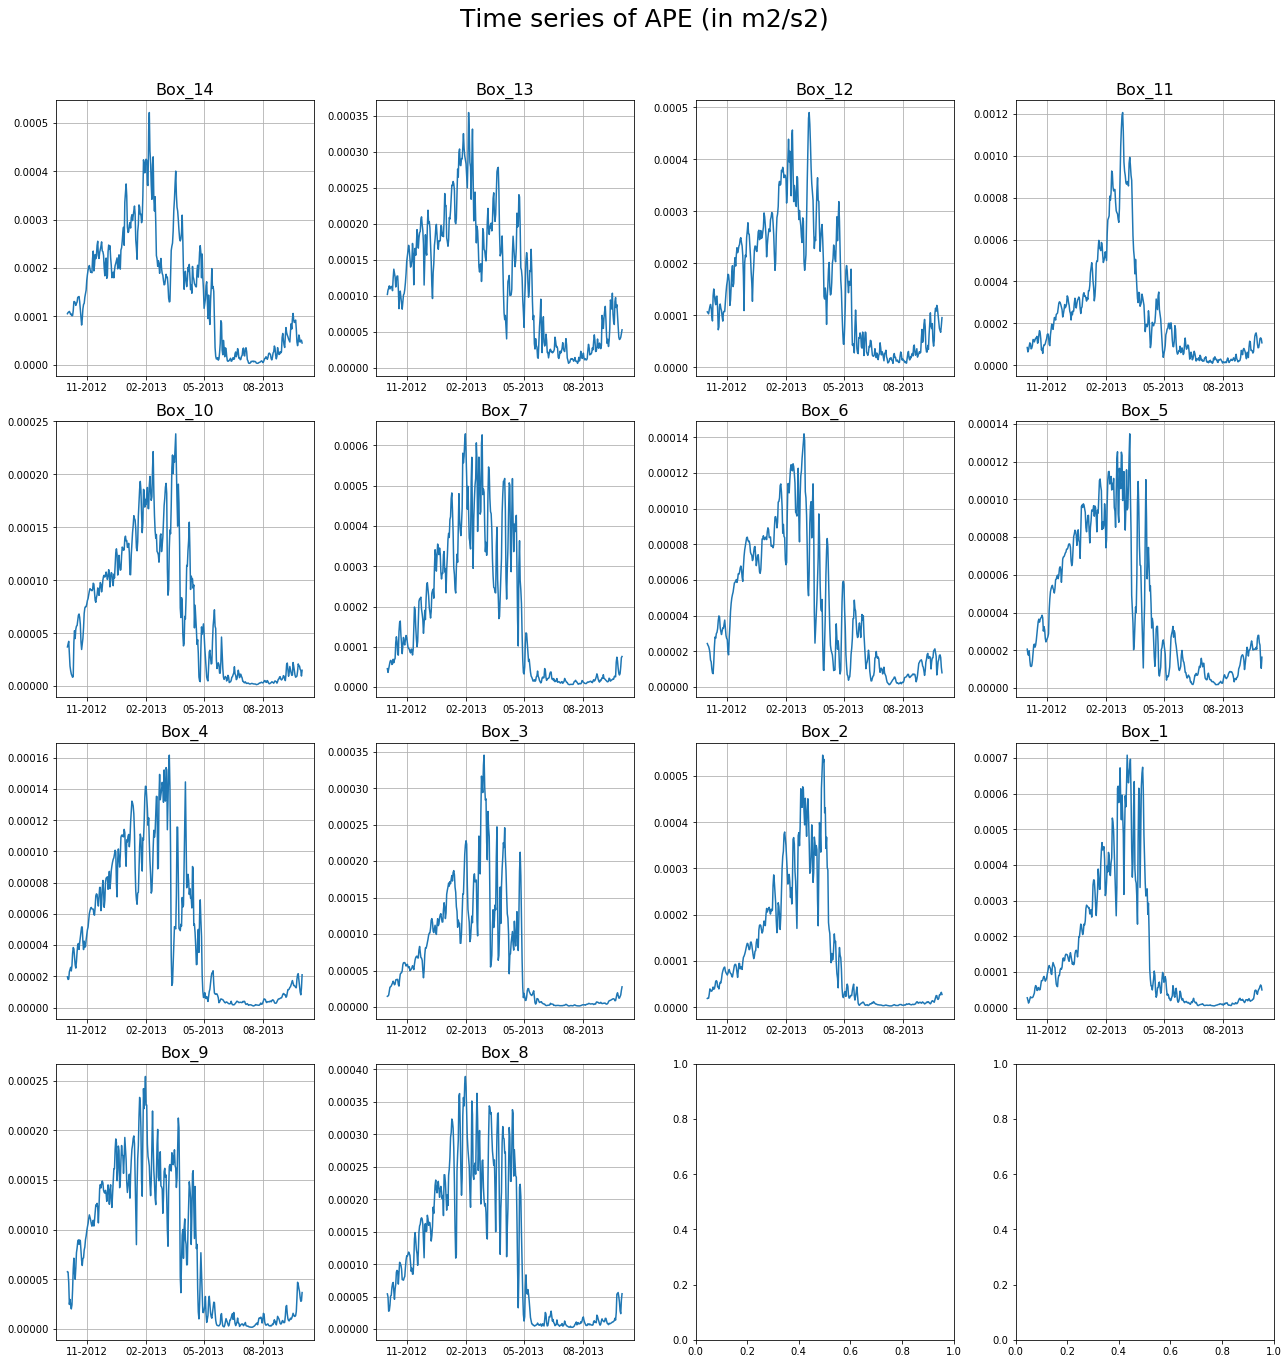

In [12]:
fig, axs = plt.subplots(4,4, figsize=(18, 18))
axs = axs.ravel()
title = 'Time series of APE (in m2/s2)'
plt.suptitle(title,size = 25,y=1.05)
i = 0
for k,box in enumerate(boxes):
    
    axs[i].plot(time_counter,wb_boxes_yr[:,k])
    axs[i].set_title(box.name,size=16)
    axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    axs[i].grid(True)
    #axs[i].set_xticklabels(labels)
    i = i + 1
    fig.tight_layout()
    
plt.savefig("NATL60_sub_vert_buoy_flx_param.png")